In [1]:
import glob
import os
from pathlib import Path
import pandas as pd

def data_cleaning(path):
    df = pd.read_csv(path,encoding="cp932",header=2)
    df.drop(columns=["気温(℃).1","気温(℃).2",
                    "降水量(mm).2","降水量(mm).3","降雪(cm).2","降雪(cm).3","積雪(cm).2","積雪(cm).3","日照時間(時間).2","日照時間(時間).3",
                    "風速(m/s).1","風速(m/s).2","風速(m/s).3","風速(m/s).4",
                    "露点温度(℃)","露点温度(℃).1","露点温度(℃).2",
                    "蒸気圧(hPa)","蒸気圧(hPa).1","蒸気圧(hPa).2",
                    "天気.1","天気.2","雲量(10分比)","雲量(10分比).1","雲量(10分比).2","相対湿度(％).1","相対湿度(％).2",
                    "海面気圧(hPa)","海面気圧(hPa).1","海面気圧(hPa).2",
                    "現地気圧(hPa).1","現地気圧(hPa).2","日射量(MJ/㎡)","日射量(MJ/㎡).1","日射量(MJ/㎡).2"
                    ],inplace=True)
    df.rename(columns={"年月日時":"datetime","降水量(mm).1":"降水なし","降雪(cm).1":"降雪なし","積雪(cm).1":"積雪なし","日照時間(時間).1":"日照なし"},inplace=True)
    df.drop(index=[0,1],inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"])

    return df

csv_list = glob.glob(str(Path.cwd().parent / "input" / "weather") + "/*.csv")
# リスト内包表記で一気にcleaningを掛け、結合、その後datetimeのダブりを削除
df_tenki = pd.concat([data_cleaning(l) for l in csv_list]).drop_duplicates(subset='datetime')
# datetimeを行に指定してsort
df_tenki.set_index("datetime",inplace=True)
df_tenki.sort_index(inplace=True)
df_tenki.to_pickle('../output/df_tenki.pkl.gz', compression='gzip') # 圧縮有り

In [ ]:
df_tenki['weekday'] = df_tenki.index.day_name()  # または .dt.weekday でも可
# 日本語の曜日表示にする場合
weekday_mapping = {
    'Monday': '月曜日',
    'Tuesday': '火曜日',
    'Wednesday': '水曜日',
    'Thursday': '木曜日',
    'Friday': '金曜日',
    'Saturday': '土曜日',
    'Sunday': '日曜日'
}
df_tenki["weekday"] = df_tenki["weekday"].map(weekday_mapping)
# datetime列から日付部分だけを抽出して新しい列を作成
df_tenki['date'] = df_tenki.index.date
# 時間帯（4時間区切り）を作成
df_tenki['time_slot'] = pd.to_datetime(df_tenki.index).hour // 4
df_tenki['time_slot'] = df_tenki['time_slot'].map({
    0: '00-04時',
    1: '04-08時',
    2: '08-12時',
    3: '12-16時',
    4: '16-20時',
    5: '20-24時'
})

In [ ]:
df_tenki[""]

datetime
2019-01-01 01:00:00    0.0
2019-01-01 02:00:00    0.0
2019-01-01 03:00:00    0.0
2019-01-01 04:00:00    0.0
2019-01-01 05:00:00    0.0
                      ... 
2023-12-31 20:00:00    0.0
2023-12-31 21:00:00    0.0
2023-12-31 22:00:00    0.0
2023-12-31 23:00:00    0.0
2024-01-01 00:00:00    0.0
Name: 日照時間(時間), Length: 43824, dtype: float64

In [25]:
df_tenki.columns


Index(['気温(℃)', '降水量(mm)', '降水なし', '降雪(cm)', '降雪なし', '積雪(cm)', '積雪なし',
       '日照時間(時間)', '日照なし', '風速(m/s)', '相対湿度(％)', '天気', '現地気圧(hPa)', 'date',
       'weekday', 'time_slot'],
      dtype='object')

In [ ]:
# 日付ごとにグループ化して気温の統計を計算
result_tenki = df_tenki.groupby('date')['気温(℃)'].agg(['mean', 'max', 'min'])
# 列名を日本語に変更
result_tenki.columns = ['平均気温', '最高気温', '最低気温']

In [26]:
df_tenki["天気"].unique()

array([ 2., 10.,  4., 11., nan,  8., 12.])

In [4]:
print("欠損チェック")
# 確認したい期間の完全なDatetimeIndexを作成（1時間おき）
expected_dates = pd.date_range(
    start='2019-01-01 01:00:00',
    end='2024-01-01 00:00:00',
    freq='H'
)
expected_df = pd.DataFrame(index=expected_dates)
expected_df.index.name = 'datetime'

# 実際のデータフレームと期待されるDatetimeIndexの差分をチェック
missing_dates = expected_df.index.difference(df.index)

# 結果の表示
if len(missing_dates) == 0:
    print("すべてのデータが揃っています。欠損はありません。")
    print("保存開始")
    df.to_csv("../input/tenki_2019-2023.csv")

else:
    print(f"欠損している日時が {len(missing_dates)} 件あります。")
    
    # 最初の10件だけ表示
    if len(missing_dates) > 10:
        print("最初の10件の欠損:")
        for i, date in enumerate(missing_dates[:10]):
            print(f"{i+1}: {date}")
        print(f"... 他 {len(missing_dates) - 10} 件")
    else:
        print("欠損している日時:")
        for i, date in enumerate(missing_dates):
            print(f"{i+1}: {date}")
    
    # 連続した欠損の分析
    print("\n連続した欠損の分析:")
    if len(missing_dates) > 0:
        # 連続した欠損期間を見つける
        missing_dates_list = missing_dates.tolist()
        gaps = []
        gap_start = missing_dates_list[0]
        
        for i in range(1, len(missing_dates_list)):
            if missing_dates_list[i] - missing_dates_list[i-1] != pd.Timedelta(hours=1):
                gaps.append((gap_start, missing_dates_list[i-1]))
                gap_start = missing_dates_list[i]
        
        # 最後のギャップを追加
        gaps.append((gap_start, missing_dates_list[-1]))
        
        # 連続欠損の表示
        for i, (start, end) in enumerate(gaps):
            duration = (end - start).total_seconds() / 3600 + 1  # 時間単位
            print(f"連続欠損 {i+1}: {start} から {end} まで ({int(duration)}時間)")
            
        # 最長の欠損期間
        longest_gap = max(gaps, key=lambda x: (x[1] - x[0]).total_seconds())
        duration = (longest_gap[1] - longest_gap[0]).total_seconds() / 3600 + 1  # 時間単位
        print(f"\n最長の連続欠損: {longest_gap[0]} から {longest_gap[1]} まで ({int(duration)}時間)")

# 各月ごとの欠損率を確認
print("\n月ごとの欠損率:")
# 全期間の年月のリストを作成
all_yearmonths = pd.Series(expected_dates).dt.to_period('M').unique()

# 実際のデータの年月ごとのカウント
if len(df.index) > 0:  # 実際のデータが存在する場合
    actual_counts = df.groupby(df.index.to_period('M')).size()
    
    for ym in all_yearmonths:
        # 各月の期待される時間数を計算
        month_start = ym.start_time
        month_end = ym.end_time
        expected_hours = pd.date_range(start=max(month_start, expected_dates[0]), 
                                      end=min(month_end, expected_dates[-1]), 
                                      freq='H').size
        
        # 実際の時間数
        actual_hours = actual_counts.get(ym, 0)
        
        # 欠損率を計算
        missing_rate = (expected_hours - actual_hours) / expected_hours * 100 if expected_hours > 0 else 0
        
        # 10%以上欠損している月を強調表示
        if missing_rate >= 10:
            print(f"{ym}: 期待={expected_hours}時間, 実際={actual_hours}時間, 欠損率={missing_rate:.2f}% ⚠️")
        else:
            print(f"{ym}: 期待={expected_hours}時間, 実際={actual_hours}時間, 欠損率={missing_rate:.2f}%")

欠損チェック


/var/folders/ck/8bxh7p5d465fgrv1k4m4rfc40000gn/T/ipykernel_5886/3181086215.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_dates = pd.date_range(


NameError: name 'df' is not defined

<Axes: >

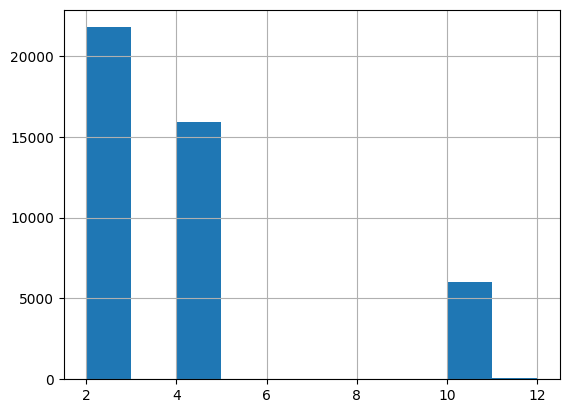

In [101]:
df["天気"].hist()

In [ ]:
df['気温'].value_counts().sort_index()

天気
2.0     21771
4.0     15897
8.0        12
10.0     6011
11.0       22
12.0       33
Name: count, dtype: int64

品質情報
| 値 | 意味           | 解説 |
|----|--------------|------------------------------------|
| 0  | 統計しない   | 観測（統計）対象外の要素 |
| 1  | 資料なし、未報告 | 欠測（統計値が得られない） |
| 2  | 利用不適値   | 利用に適さない |
| 3  | 疑問値       | 値が非常に疑わしい |
| 4  | 資料不足値   | 統計を行うためのもとデータに一定以上の欠落がある |
| 5  | 準正常値     | 値がやや疑わしい（統計を行うための、もとデータに若干の欠落がある） |
| 8  | 正常値       | 品質に問題がない（統計を行うための、もとデータに欠落がない） |  

現象なし情報  
現象がなければ1

| 項番 | 記号 | 天気 | 観測者による観測 | 自動観測 |
|------|------|------|----------------|--------|
| 1  | 快晴の記号 | 快晴 | ○ | － |
| 2  | 晴の記号 | 晴 | ○ | ○ |
| 3  | 薄曇の記号 | 薄曇 | ○ | － |
| 4  | 曇の記号 | 曇 | ○ | ○ |
| 5  | 煙霧の記号 | 煙霧 | ○ | ○ |
| 6  | 砂じん嵐の記号 | 砂じん嵐 | ○ | － |
| 7  | 高い地ふぶきの記号 | 高い地ふぶき | ○ | － |
| 8  | 霧の記号 | 霧 | ○ | ○ |
| 9  | 霧雨の記号 | 霧雨 | ○ | ○ |
| 10 | しゅう雨の記号 | しゅう雨または止み間のある雨 | － | ○ |
| 11 | 降水現象の記号 | 降水 | － | ○ |
| 12 | 雨の記号 | 雨 | ○ | ○ |
| 13 | みぞれの記号 | みぞれ | ○ | ○ |
| 14 | 雪の記号 | 雪 | ○ | ○ |
| 15 | 着氷性の雨の記号 | 着氷性の雨 | － | ○ |
| 16 | 着氷性の霧雨の記号 | 着氷性の霧雨 | － | ○ |
| 17 | 凍雨の記号 | 凍雨 | － | ○ |
| 18 | 霧雪の記号 | 霧雪 | － | ○ |
| 19 | しゅう雪の記号 | しゅう雪または止み間のある雪 | － | ○ |
| 20 | あられの記号 | あられ | ○ | － |
| 21 | ひょうの記号 | ひょう | ○ | ○ |
| 22 | もやの記号 | もや | － | ○ |
| 23 | 細氷の記号 | 細氷 | － | ○ |
| 24 | 雷の記号 | 雷 | ○ | ○ |

**注:** 観測者による観測で該当する天気が複数存在する場合は、項番の大きい方を優先する。